## Tutorial - 0: Continuous Forward Burgers

Welcome to our first tutorial on Physics-Informed Neural Networks (PINNs) our new package, **`pinnsjax`**! This guide aims to introduce you to the integration of deep learning and scientific computing via PINNs, which embed physical laws into neural network training.

#### Overview:

- **Mesh Generation and Sampling:** Understanding how to create and use meshes for training PINNs, crucial for defining the domain of our problem.
- **Neural Network Model with PINNs:** How to build and structure a neural network for physical law integration.
- **Physical Laws in Neural Networks:** Detailing the implementation of differential equations within the network using `pde_fn` and `output_fn`.
- **Training and Validation:** Utilizing our Trainer to train our model, including defining the training data, initial conditions, and handling boundary conditions.
- **Results Visualization:** Saving and analyzing the outcomes of your PINN models.

#### Install `pinnsjax`

In [1]:
!pip install pinnsjax

#### Import Libraries

In [1]:
from typing import Dict

import jax
import numpy as np

import pinnsjax

### Define Mesh

Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnsjax`, there are primarily two approaches to define this mesh:


- **Defining Time and Spatial Domains Separately:** Here, we use `pinnsjax.data.TimeDomain` and `pinnsjax.data.Interval` for creating 1-D spatial domains. These domains are then used to define a `pinnsjax.data.Mesh`.

- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnsjax.data.PointCloud`.

Both approaches should ideally yield the same results.

#### Option 1: Defining Mesh with Separate Time and Spatial Domains

We start by defining a function to read and preprocess the solution data from a file. The output should be a dictionary.

In [27]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in Mesh class.
    """

    data = pinnsjax.utils.load_data(root_path, "burgers_shock.mat")
    exact_u = np.real(data["usol"])
    return {"u": exact_u}

Now, define the time and spatial domains for mesh generation. The choice of these parameters depends on the specific problem being solved and should be set accordingly.

In [28]:
time_domain = pinnsjax.data.TimeDomain(t_interval=[0, 0.99], t_points = 100)
spatial_domain = pinnsjax.data.Interval(x_interval=[-1, 1], shape = [256, 1])

The mesh is then defined using the time and spatial domains along with the read_data_fn function. 

In [29]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

#### Option 2: Using Point Clouds

For scenarios where the spatial and temporal data along with solutions are directly available (e.g., from experimental measurements), we can create a mesh using `pinnsjax.data.PointCloud`.

**Note:** It's crucial to format the spatial and temporal domain dimensions correctly. Specifically:

- **Spatial Domain:** Each axis should be structured in the shape of $(N \times 1)$, where $N$ represents the number of spatial points.
- **Time Domain:** This should be formatted as $(T \times 1)$, where $T$ indicates the number of time steps.
- **Solution Data:** Each solution variable (e.g., temperature, velocity) should be in the shape of $(N \times T)$, aligning with the spatial and temporal points.

In [5]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in PointCloud class.
    """

    data = pinnsjax.utils.load_data(root_path, "burgers_shock.mat")

    x = data['x']
    t = data['t']
    exact_u = np.real(data["usol"])
    
    return pinnsjax.data.PointCloudData(
            spatial=[x], time=[t], solution={"u": exact_u}
    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [6]:
mesh = pinnsjax.data.PointCloud(root_dir='./data',
                                read_data_fn=read_data_fn)

### Define Train datasets

For solving Burgers PDE, we have:
- Initial condition
- Dirichlet boundary condition
- Collection points for the PDE.

#### Initial Condition

Let's start with initial condition of the Burgers.
$$ u(0, x) = -\sin(\pi x) $$

For defining initial condition, again we have two options.

- **Sample from the data.**
- **Defining a function for calculating initial condition.**

##### Set number of samples

In [7]:
N0 = 50

##### Option 1: Sample from the data

In [8]:
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

I0000 00:00:1716428270.113213   30367 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


##### Option 2: Defining a function for calculating initial condition

The input of `initial_fun` should be the same as spatial domain of the problem.

In [9]:
def initial_fun(x):
    return {'u': - np.sin(x*np.pi)}

In [10]:
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      initial_fun = initial_fun,
                                      solution = ['u'])

The `solution` attribute in `pinnsjax.data.InitialCondition` specifies the solutions (`u` in our case) to be sampled for initial conditions.

#### Periodic Boundary Condition

The `pinnsjax.data.DirichletBoundaryCondition` is used to specify fixed values of a function at specific points or boundaries in the domain. In our case, for the Burgers equation, we have:

$$ u(t,-1) = u(t, 1) = 0 $$

In [11]:
N_b = 50
di_b = pinnsjax.data.DirichletBoundaryCondition(mesh = mesh,
                                                num_sample = N_b,
                                                solution = ['u'])

#### Mesh Sampler for collection points and solutions

In our problem, the partial differential equations (PDEs) governing the dynamics are given by:

$$ f_u := u_t + uu_x - (0.01/\pi)u_{xx}$$

To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnsjax.data.MeshSampler` for this purpose, specifying the following:

- **Number of Sample Points (N_f):** We choose to sample 20,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.
- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.
- **Collection Points:** We define `['f_u']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.

Here's the code to implement this sampler:

In [12]:
N_f = 20000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

### Define Validation dataset

For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `u`.

**Note:** If `num_sample` is not specified, the sampler will use the entire mesh.

In [13]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

### Define Neural Networks

Here, we try to define a neural network for solving the problem. For defining a neural network, we should set number of layers and the name of the outputs. Also, domain bounds should be defined. The `lb` and `ub` parameters represent the lower and upper bounds of the spatial-temporal domain, helping in normalizing inputs to the network. Therefore, the inputs of this network are `x` and `t`, and the output of this network is `u`.

In [14]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

### Define `pde_fn` function

Now, we define `pde_fn`.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points. 

#### `pde_fn` function

**Note:** `pde_fn` should always have Five inputs:
- **Functional Model:** This is the neural network or any other functional approximation model, used for computing gradients with JAX automatic differentiation.
- **Model's Prameters:** These include all trainable parameters of the model as well as any additional parameters needed for inverse problems.
- **Outputs:** The outputs of the network, typically a dictionary. For the Burgers' equation, this dictionary should have at least one key `u` representing the function `u(t, x)`.
- **Spatial domains:** These are the spatial domain variables. In our case, because our problem has 1-D spatial domain, the input just have `x`. For example, if we had 2-D space, we need another input for that dimention. For example, the inputs from `(functional_model, params, outputs, x, t)` will be changed to `(functional_model, params, outputs, x, y, t)`.
- **Time domin:** The last input of `pde_fn` function always should be time.

In [15]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):   
    """Define the partial differential equations (PDEs)."""

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t + outputs["u"] * u_x - (0.01 / np.pi) * u_xx

    return outputs

### Define PINNDataModule and PINNModule

To integrate with Lightning, we utilize two specialized modules:

- `PINNDataModule` manages data.
- `PINNModule` handles the model and compilation.

#### Define `PINNDataModule`
Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [16]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

#### Define `PINNModule`

`PINNModule` handle several things. Here, we will explore the inputs of this class:

- **net:**  The neural network model to be used for approximating solutions.
- **pde_fn:** The partial differential equation (PDE) function defining the PDE to solve.
- **optimizer:**  (Optional) The optimizer used for training the neural network. The default is Adam
- **loss_fn:** (Optional) The loss function to use, either "sse" or "mse". The default is "sse".
- **extra_variables:** (Optional) Extra variables in inverse problems. The default is None.
- **runge_kutta:** (Optional) Runge-Kutta method for solving PDEs in discrete mode. The default is None.
- **jit_compile:** (Optional) Flag to enable JIT compilation. The default is True.

In this example, we initalize `PINNModule` with defined variables. We set Adam optimizer and try to compile the model with XLA compiler. The loss function here is Mean Square Error (MSE).

In [17]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse')

### Setting Up the Trainer

For training our model, we write a custom trainer. Arguments that you can set are:

- **max_epochs:** Maximum number of training epochs.
- **check_val_every_n_epoch:** (Optional) Frequency of validation checks within epochs. Defualt is 1.
- **enable_progress_bar:** (Optional) Flag to enable/disable the progress bar. Defualt is True.


In [18]:
trainer = pinnsjax.Trainer(max_epochs=20000, check_val_every_n_epoch=1000)

### Training

In [19]:
trainer.fit(model=model, datamodule=datamodule)

20000/20000 100%|██████████|[03:44<00:00, 88.97it/s, val/loss: 0.0001, val/error_u: 0.0120, train/loss: 0.0001: ]


### Validation

In [20]:
trainer.validate(model=model, datamodule=datamodule)

(Array(4.981182e-05, dtype=float32), {'u': Array(0.01148839, dtype=float32)})

### Plotting

For plotting, we need predict the results, and then, we should concatenate the results.

In [21]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)

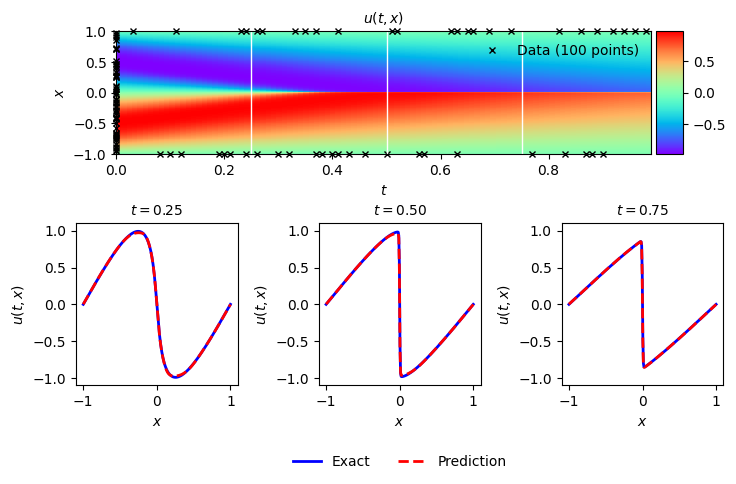

In [31]:
for sol_key, pred in preds_dict.items():
    preds_dict[sol_key] = pred
pinnsjax.utils.plot_burgers_continuous_forward(mesh=mesh,
                                               preds=preds_dict,
                                               train_datasets=train_datasets,
                                               val_dataset=val_dataset,
                                               file_name='out')